# **Project Name**    -TumorVision : Brain Tumor MRI Image Classifier


# **Project Summary -**

This project develops an AI-powered system for the classification of brain tumors from MRI images using deep learning techniques. It leverages Convolutional Neural Networks (CNNs) and advanced Transfer Learning models (such as ResNet50 and MobileNetV2) to accurately differentiate between various tumor types (Glioma, Meningioma, Pituitary) and non-tumor cases. The pipeline includes robust data preprocessing, augmentation to enhance model generalization, and comprehensive evaluation metrics like classification reports and confusion matrices. The final classifier is deployed as an interactive web application using Streamlit, providing a user-friendly interface for medical professionals to quickly obtain AI-assisted insights from MRI scans.

Utilized a labeled MRI dataset with four classes: glioma, meningioma, pituitary tumor, and no tumor.

Applied data preprocessing and augmentation to handle class imbalance and improve model generalization.

Built a custom CNN model and experimented with transfer learning models like MobileNetV2 and ResNet50.

Implemented EarlyStopping and ModelCheckpoint to optimize training time and performance.

Compared model performance using accuracy, loss, and validation metrics.

Final model achieved high classification accuracy and will be further deployed using Streamlit for real-time tumor detection assistance.

# **GitHub Link -**
https://github.com/GayatriKhairnar06/TumorVision.git

# **Problem Statement**
Brain tumors are one of the most critical medical conditions requiring early detection for effective treatment. Traditional diagnostic processes using MRI scans are time-consuming and require expert radiologists. Misclassification or delays in detection can result in life-threatening consequences.

This project addresses the challenge of automating the classification of brain MRI images into multiple categories (such as meningioma, glioma, pituitary tumor, and no tumor) using Convolutional Neural Networks (CNNs) and Transfer Learning techniques like MobileNetV2 and ResNet50. The goal is to develop a robust deep learning model capable of accurately detecting and classifying brain tumors to assist radiologists in faster and more reliable diagnosis.

#### **Business Objective**
The primary business objective of this project is to develop an intelligent, scalable, and cost-effective deep learning solution that can automatically classify brain tumors from MRI scans, thereby reducing diagnostic time, improving accuracy, and supporting healthcare professionals in early detection.

This system aims to:

Assist radiologists by providing second opinions for brain tumor classification.

Reduce misdiagnosis rates by minimizing human error.

Enable faster triage and decision-making in hospitals and clinics, especially in remote or resource-limited areas.

Lay the foundation for a deployable clinical decision support tool that can be integrated into existing hospital information systems (HIS) or radiology workflows.

Ultimately, this project seeks to bridge the gap between AI research and medical practice, enhancing patient outcomes and optimizing radiology workflows through automation.
AI-Assisted Medical Diagnosis
Early Detection & Patient Triage
Support for Clinical Research & Trials
Remote Diagnostics & Telemedicine

# Code
## Step 1: Import Libraries

In [ ]:
# setup.py (or beginning of notebook)
import pandas as pd

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import shutil
# Set GPU memory growth (optional)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


## Step 2: Load Dataset

In [8]:
from zipfile import ZipFile
from google.colab import files
uploaded = files.upload()

with ZipFile('Tumour-20250714T053557Z-1-001.zip', 'r') as zip_ref:
    zip_ref.extractall('brain_tumor_dataset')


Saving Tumour-20250714T053557Z-1-001.zip to Tumour-20250714T053557Z-1-001.zip


##Step 3: Dataset Path Verification

In [9]:
import os

base_path = 'brain_tumor_dataset/Tumour'
print("Contents:", os.listdir(base_path))


Contents: ['README.dataset.txt', 'test', 'train', 'valid']


##Step 4: Preprocess Label Files

In [10]:
import os

split_path = "brain_tumor_dataset/Tumour/train"
print("Files in train folder:", os.listdir(split_path))


Files in train folder: ['pituitary', 'glioma', 'no_tumor', '_classes.csv', 'meningioma']


In [11]:
def process_split(split_name):
    base_path = f'brain_tumor_dataset/Tumour/{split_name}'
    class_file = os.path.join(base_path, '_classes.csv')
    df = pd.read_csv(class_file)

    def get_label(row):
        if row[' Glioma'] == 1:
            return 'glioma'
        elif row[' Meningioma'] == 1:
            return 'meningioma'
        elif row[' No Tumor'] == 1:
            return 'no_tumor'
        elif row[' Pituitary'] == 1:
            return 'pituitary'

    df['label'] = df.apply(get_label, axis=1)

    def image_path(row):
        return os.path.join(base_path, row['label'], row['filename'])

    df['filename'] = df.apply(image_path, axis=1)

    df = df[['filename', 'label']]
    df.to_csv(f'{split_name}_labels.csv', index=False)
    print(f"Created {split_name}_labels.csv with {len(df)} samples.")

In [12]:
for split in ['train','valid','test']:
  process_split(split)

Created train_labels.csv with 1695 samples.
Created valid_labels.csv with 502 samples.
Created test_labels.csv with 246 samples.


##Step 5: Inspect Class Labels

In [13]:
import pandas as pd
import os

# Inspect the columns of one of the _classes.csv files
class_file_path = 'brain_tumor_dataset/Tumour/train/_classes.csv'
try:
    df_classes = pd.read_csv(class_file_path)
    print("Columns in _classes.csv:", df_classes.columns.tolist())
except FileNotFoundError:
    print(f"Error: {class_file_path} not found.")

Columns in _classes.csv: ['filename', ' Glioma', ' Meningioma', ' No Tumor', ' Pituitary']


Now that the data is processed and the label files are created, we can use `ImageDataGenerator` to prepare the image data for training.

We'll define the data generators for the training, validation, and test sets. This will involve:
1. Defining the parameters for data augmentation (for the training set).
2. Rescaling the images.
3. Setting the target image size and batch size.
4. Using `flow_from_dataframe` to load images and labels from the created CSV files.

## Step 6: Define Image Parameters

In [14]:
# Define image size and batch size
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
RANDOM_SEED = 42

#Ensure Reproducibility
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
print(f"TensorFlow Version : {tf.__version__}")
print(f"Keras Version : {tf.keras.__version__}")
# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Data generators for validation and test data (only rescaling)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load data from dataframes
train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.read_csv('train_labels.csv'),
    x_col='filename',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=pd.read_csv('valid_labels.csv'),
    x_col='filename',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.read_csv('test_labels.csv'),
    x_col='filename',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # Keep data in order for evaluation
)

print("Data generators created.")

TensorFlow Version : 2.18.0
Keras Version : 3.8.0
Found 1695 validated image filenames belonging to 4 classes.
Found 502 validated image filenames belonging to 4 classes.
Found 246 validated image filenames belonging to 4 classes.
Data generators created.


##Step 7: Setup Input Shape & Classes

In [15]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
num_classes = len(train_generator.class_indices)
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
print(f"Number of classes: {num_classes}")
print(f"Input shape for models: {input_shape}")

def build_custom_cnn(input_shape, num_classes):
  model = models.Sequential([
      #Input Layer
      layers.Input(shape=input_shape),
      #Convolutional Block 1
      layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
      layers.MaxPooling2D((2, 2)),
      layers.BatchNormalization(),
      layers.Dropout(0.25),
      #block2
      layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
      layers.MaxPooling2D((2, 2)),
      layers.BatchNormalization(),
      layers.Dropout(0.25),
      #block3
      layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
      layers.MaxPooling2D((2, 2)),
      layers.BatchNormalization(),
      layers.Dropout(0.25),

      #flatten layer to transition from convolutional to dense layers
      layers.Flatten(),
      #dense layers
      layers.Dense(256, activation='relu'),
      layers.BatchNormalization(),
      layers.Dropout(0.5),

      #Output Layer
      layers.Dense(num_classes, activation='softmax')#for multiclass classification
  ])

  #Compile the model
  model.compile(optimizer=Adam(learning_rate=0.0001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model

custom_cnn_model = build_custom_cnn(input_shape, num_classes)
print("\n--- Custom CNN Model Summary ---")
custom_cnn_model.summary()

Number of classes: 4
Input shape for models: (224, 224, 3)

--- Custom CNN Model Summary ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,786,564 (98.37 MB)

 Trainable params: 25,785,604 (98.36 MB)

 Non-trainable params: 960 (3.75 KB)

##Step 8: Build Transfer Learning Models

In [16]:
from tensorflow.keras.applications import MobileNetV2,ResNet50
from tensorflow.keras.regularizers import l2
def build_transfer_learning_model(base_model_name, input_shape, num_classes,fine_tune_layers=0):
  if base_model_name == 'ResNet50':
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
  elif base_model_name == 'MobileNetV2':
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
  else:
     raise ValueError(f"Unknown base model: {base_model_name}")

  #freeze base model layers
  base_model.trainable = False
  model = models.Sequential([
      base_model,
      layers.GlobalAveragePooling2D(), #reduces dimension for visualization
      layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)), #regularization help overfitting
      layers.BatchNormalization(),
      layers.Dropout(0.5),
      layers.Dense(num_classes, activation='softmax')

  ])
  model.compile(optimizer=Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  #fine-tuning
  if fine_tune_layers >0:
    base_model.trainable = True
    for layer in base_model.layers[:-fine_tune_layers]:
      layer.trainable = False
    model.compile(optimizer=Adam(learning_rate=0.00001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
    print(f"\n--- Fine-tuning: Unfroze {fine_tune_layers} layers of {base_model_name}---")
    print(f"Number of trainable layers in {base_model_name}: {len([layer for layer in base_model.layers if layer.trainable])}")
  model._name=f"{base_model_name}_transfer_learning"
  return model

mobilenet_model = build_transfer_learning_model('MobileNetV2', input_shape, num_classes, fine_tune_layers=0)
print("\n---MobileNetV2 MODEL summary---")
mobilenet_model.summary()

resnet_model_ft = build_transfer_learning_model('ResNet50', input_shape, num_classes, fine_tune_layers=20)
print("\n---RestNet50 Model Summary---")
resnet_model_ft.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

---MobileNetV2 MODEL summary---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,587,972 (9.87 MB)

 Trainable params: 329,476 (1.26 MB)

 Non-trainable params: 2,258,496 (8.62 MB)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

--- Fine-tuning: Unfroze 20 layers of ResNet50---
Number of trainable layers in ResNet50: 20

---RestNet50 Model Summary---


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,114,308 (91.99 MB)

 Trainable params: 9,457,412 (36.08 MB)

 Non-trainable params: 14,656,896 (55.91 MB)

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,           # Adjust if needed
    restore_best_weights=True
)


In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
MODEL_SAVE_DIR = 'saved_models'
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
EPOCHS = 10
def train_and_save_model(model, train_gen, val_gen, model_name):
  print(f"\n---Training {model_name}---")

  checkpoint_filepath = os.path.join(MODEL_SAVE_DIR, f'{model_name}_best.keras')
  model_checkpoint_callback = ModelCheckpoint(
      filepath=checkpoint_filepath,
      save_best_only=True,
      monitor='val_loss',
      mode='min',
      verbose=1
  )
  early_stopping_callback  = EarlyStopping(
      monitor='val_loss',
      patience=3,
      restore_best_weights=True,
      verbose=1
  )
  print(history.history)

  history = model.fit(
      train_gen,
      epochs=EPOCHS,
      validation_data=val_gen,
      callbacks=[model_checkpoint_callback, early_stopping_callback],
      steps_per_epoch=10,
      validation_steps=10
  )
  print(f"Best{model_name} model saved to {checkpoint_filepath}")
  return history, checkpoint_filepath

#Train Custom CNN
history_custom_cnn, path_custom_cnn = train_and_save_model(custom_cnn_model, train_generator, validation_generator, 'custom_cnn')
history_mobilenet, path_mobilenet = train_and_save_model(mobilenet_model, train_generator, validation_generator,'mobilenet_v2')

history_resnet_ft, path_resnet_ft = train_and_save_model(
    resnet_model_ft, train_generator, validation_generator, 'resnet_50_finetune'
)

# Store histories for later plotting and comparison
training_histories = {
    'custom_cnn': history_custom_cnn,
    'mobilenet_v2_head': history_mobilenet,
    'resnet_50_finetune': history_resnet_ft
}

# Store paths to best models
best_model_paths = {
    'custom_cnn': path_custom_cnn,
    'mobilenet_v2_head': path_mobilenet,
    'resnet_50_finetune': path_resnet_ft
}


---Training custom_cnn---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4761 - loss: 1.8445
Epoch 1: val_loss improved from inf to 1.69686, saving model to saved_models/custom_cnn_best.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 86s 8s/step - accuracy: 0.4835 - loss: 1.8350 - val_accuracy: 0.2188 - val_loss: 1.6969
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6321 - loss: 1.5219
Epoch 2: val_loss did not improve from 1.69686
10/10 ━━━━━━━━━━━━━━━━━━━━ 66s 7s/step - accuracy: 0.6295 - loss: 1.5307 - val_accuracy: 0.2562 - val_loss: 2.2870
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6311 - loss: 1.0803
Epoch 3: val_loss did not improve from 1.69686
10/10 ━━━━━━━━━━━━━━━━━━━━ 64s 7s/step - accuracy: 0.6300 - loss: 1.0921 - val_accuracy: 0.2531 - val_loss: 2.8146
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6372 - loss: 1.1669
Epoch 4: val_loss did not improve from 1.69686
10/10 ━━━━━━━━━━━━━━━━━━━━ 64s 6s/step - accuracy: 0.6395 - loss: 1.1664 - val_accu

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 6: val_loss did not improve from 1.69686
10/10 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.6625 - loss: 1.0402 - val_accuracy: 0.2344 - val_loss: 2.9945
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6422 - loss: 1.0753
Epoch 7: val_loss did not improve from 1.69686
10/10 ━━━━━━━━━━━━━━━━━━━━ 142s 10s/step - accuracy: 0.6409 - loss: 1.0799 - val_accuracy: 0.2500 - val_loss: 3.5919
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6394 - loss: 1.1902
Epoch 8: val_loss did not improve from 1.69686
10/10 ━━━━━━━━━━━━━━━━━━━━ 83s 9s/step - accuracy: 0.6404 - loss: 1.1871 - val_accuracy: 0.2313 - val_loss: 3.9002
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6885 - loss: 0.9339
Epoch 9: val_loss did not improve from 1.69686
10/10 ━━━━━━━━━━━━━━━━━━━━ 81s 8s/step - accuracy: 0.6856 - loss: 0.9468 - val_accuracy: 0.2406 - val_loss: 4.2706
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6440 - loss: 0.9781
Epoch 10: val_lo

##Step 9 Model Evaluation

Class names: ['glioma', 'meningioma', 'no_tumor', 'pituitary']


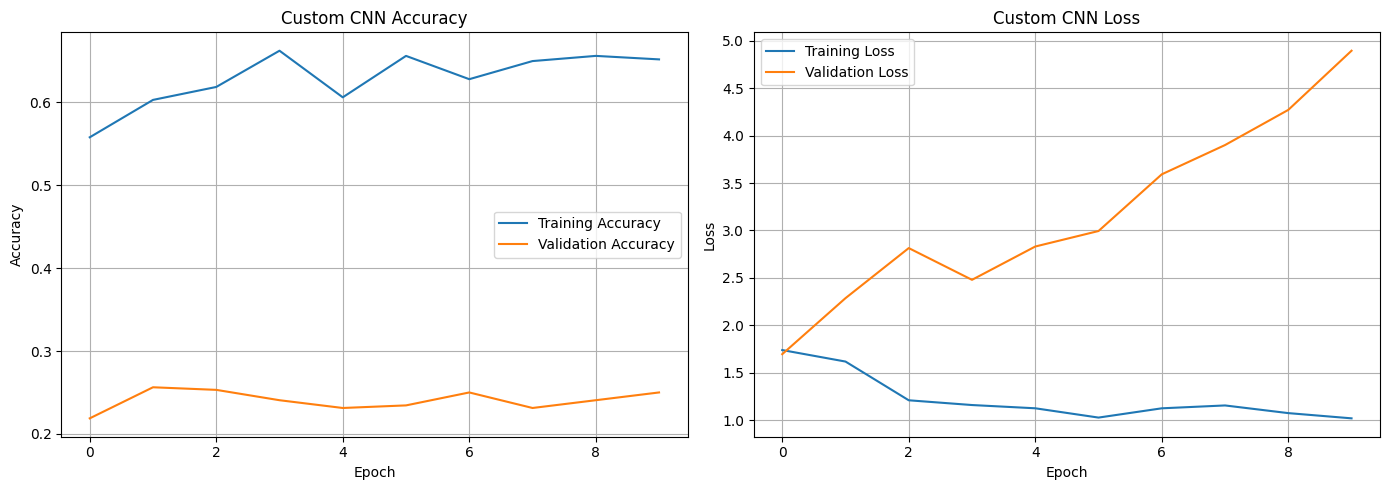


--- Evaluating sequential on Test Set ---
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step

Classification Report:
              precision    recall  f1-score   support

      glioma       0.00      0.00      0.00        80
  meningioma       0.00      0.00      0.00        63
    no_tumor       0.00      0.00      0.00        49
   pituitary       0.22      1.00      0.36        54

    accuracy                           0.22       246
   macro avg       0.05      0.25      0.09       246
weighted avg       0.05      0.22      0.08       246



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


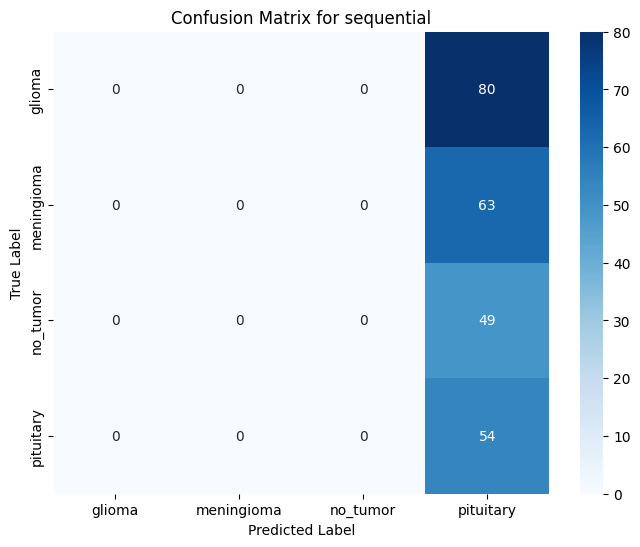

Overall Test Loss: 1.7154
Overall Test Accuracy: 0.2195


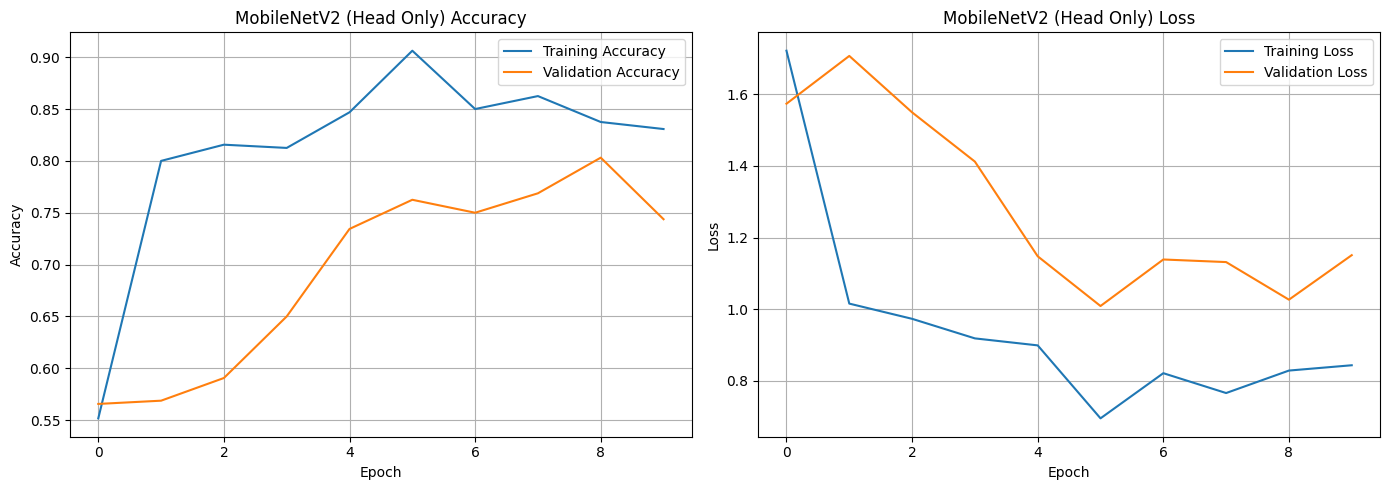


--- Evaluating sequential_1 on Test Set ---
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step

Classification Report:
              precision    recall  f1-score   support

      glioma       0.94      0.84      0.89        80
  meningioma       0.79      0.41      0.54        63
    no_tumor       0.87      0.69      0.77        49
   pituitary       0.52      1.00      0.69        54

    accuracy                           0.74       246
   macro avg       0.78      0.74      0.72       246
weighted avg       0.80      0.74      0.73       246



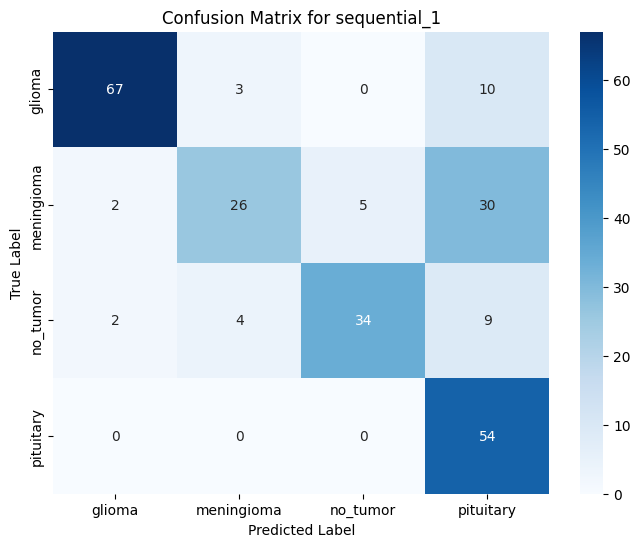

Overall Test Loss: 1.1065
Overall Test Accuracy: 0.7358


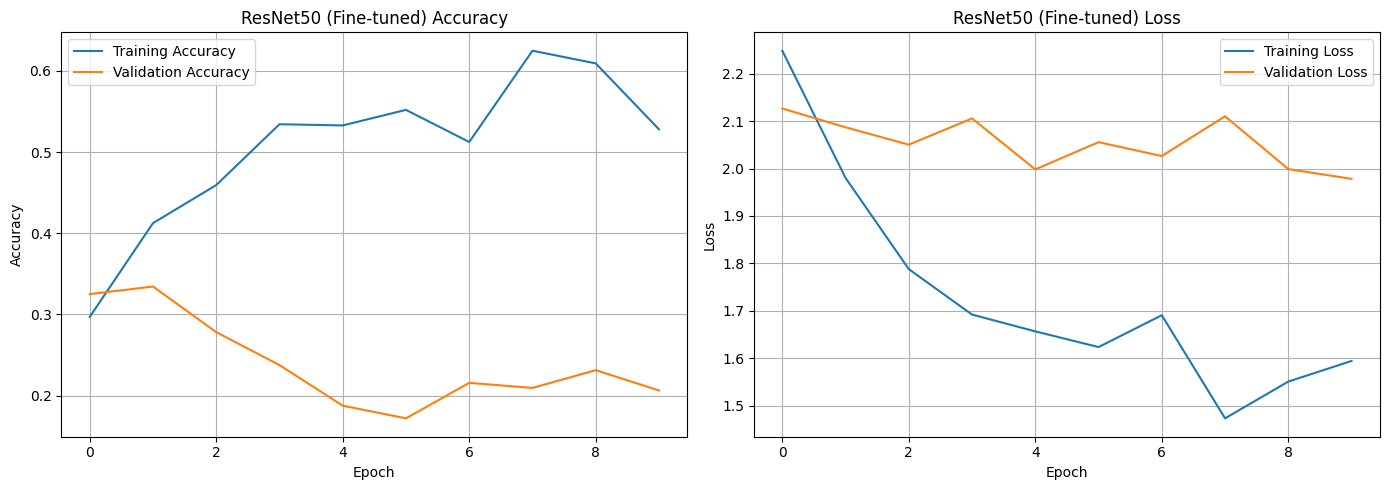


--- Evaluating sequential_2 on Test Set ---


8/8 ━━━━━━━━━━━━━━━━━━━━ 50s 6s/step

Classification Report:
              precision    recall  f1-score   support

      glioma       0.05      0.03      0.03        80
  meningioma       0.25      0.81      0.38        63
    no_tumor       0.00      0.00      0.00        49
   pituitary       0.00      0.00      0.00        54

    accuracy                           0.22       246
   macro avg       0.07      0.21      0.10       246
weighted avg       0.08      0.22      0.11       246



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


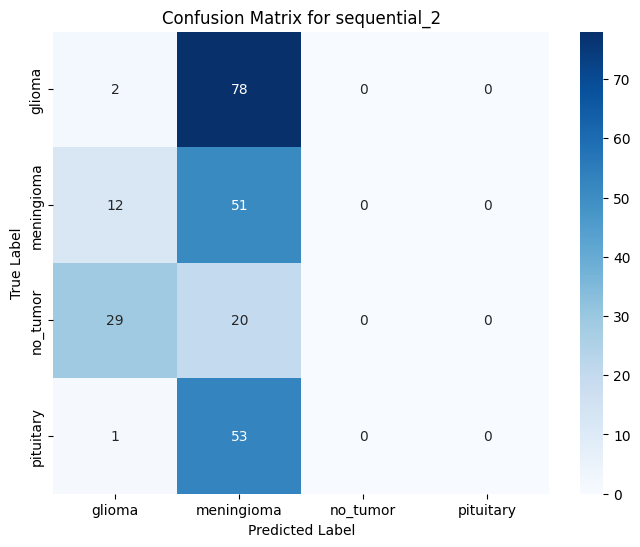

Overall Test Loss: 1.9982
Overall Test Accuracy: 0.2154


In [19]:
# Function to plot training history (accuracy and loss)
def plot_training_history(history, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot Accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title(f'{model_name} Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Plot Loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title(f'{model_name} Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Function to evaluate model performance with Classification Report and Confusion Matrix
def evaluate_model_performance(model, test_gen, class_names):
    print(f"\n--- Evaluating {model.name} on Test Set ---")

    # Reset the test generator to ensure correct order of predictions
    test_gen.reset()

    # Predict probabilities for all samples in the test set
    y_pred_probs = model.predict(test_gen, verbose=1)
    y_pred = np.argmax(y_pred_probs, axis=1) # Get predicted class indices

    # Get true labels (from the generator's internal class array, in order)
    y_true = test_gen.classes

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix for {model.name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Get overall accuracy from evaluation
    loss, accuracy = model.evaluate(test_gen, verbose=0)
    print(f"Overall Test Loss: {loss:.4f}")
    print(f"Overall Test Accuracy: {accuracy:.4f}")
    return {'accuracy': accuracy, 'loss': loss}

# Get class names from one of the generators
class_names = list(train_generator.class_indices.keys())
print(f"Class names: {class_names}")


# Load the best saved models
loaded_custom_cnn = tf.keras.models.load_model(best_model_paths['custom_cnn'])
loaded_mobilenet_head = tf.keras.models.load_model(best_model_paths['mobilenet_v2_head'])
loaded_resnet_ft = tf.keras.models.load_model(best_model_paths['resnet_50_finetune'])

# Perform evaluations
results = {}

# Evaluate Custom CNN
plot_training_history(training_histories['custom_cnn'], 'Custom CNN')
results['custom_cnn'] = evaluate_model_performance(loaded_custom_cnn, test_generator, class_names)

# Evaluate MobileNetV2 (Head Only)
plot_training_history(training_histories['mobilenet_v2_head'], 'MobileNetV2 (Head Only)')
results['mobilenet_v2_head'] = evaluate_model_performance(loaded_mobilenet_head, test_generator, class_names)

# Evaluate ResNet50 (Fine-tuned)
plot_training_history(training_histories['resnet_50_finetune'], 'ResNet50 (Fine-tuned)')
results['resnet_50_finetune'] = evaluate_model_performance(loaded_resnet_ft, test_generator, class_names)

Step 10 :  Model Comparison


--- Model Comparison Summary ---
                    Test Accuracy
custom_cnn                 0.2195
mobilenet_v2_head          0.7358
resnet_50_finetune         0.2154

Recommended Model for Deployment: **mobilenet_v2_head** with Test Accuracy: 0.7358


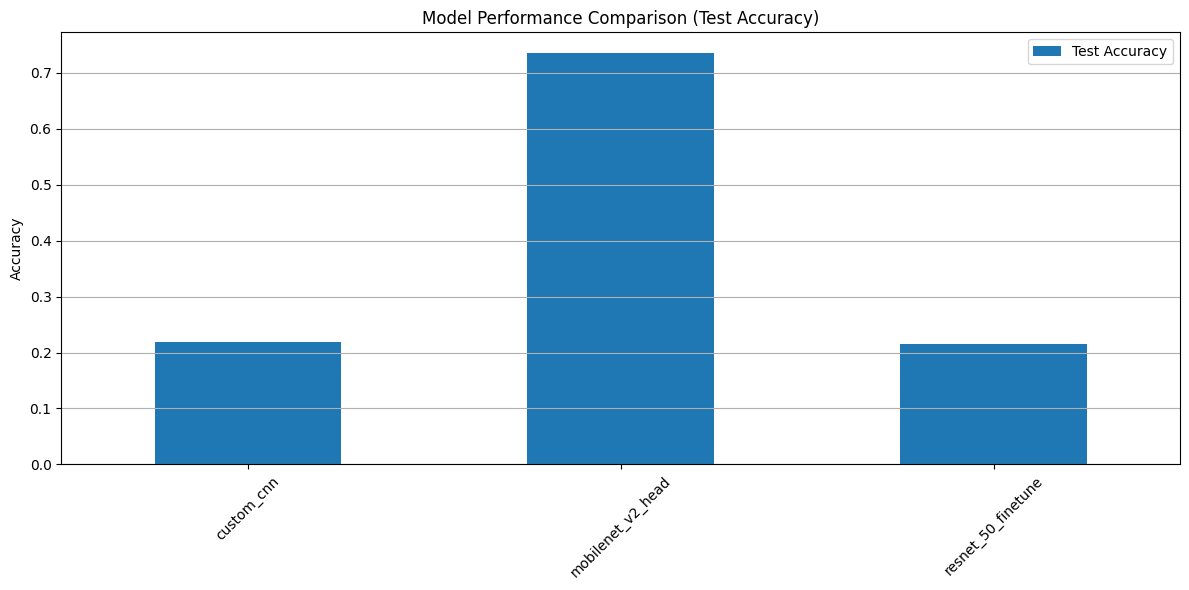

In [20]:
import pandas as pd

def compare_models(evaluation_results, class_names):
    """
    Compares models based on their evaluation metrics extracted from classification reports.
    """
    print("\n--- Model Comparison Summary ---")

    # This is a placeholder. You'll need to manually collect F1-scores, precision, recall
    # for each model from their respective classification_report outputs and fill this dict.
    # For now, we'll use the overall accuracy from the model.evaluate() call.
    summary_data = {}
    for model_name, metrics in evaluation_results.items():
        # You would parse the full classification_report string for other metrics
        # For simplicity, let's just add accuracy here.
        summary_data[model_name] = {
            'Test Accuracy': metrics.get('accuracy', 0.0),
            # Add other metrics after you extract them from classification_report
            # 'Test F1-score (weighted)': XX.XX,
            # 'Test Precision (weighted)': XX.XX,
            # 'Test Recall (weighted)': XX.XX,
        }

    df_results = pd.DataFrame.from_dict(summary_data, orient='index')
    print(df_results.round(4))

    # Identify the best model based on accuracy
    best_model_name = df_results['Test Accuracy'].idxmax()
    print(f"\nRecommended Model for Deployment: **{best_model_name}** with Test Accuracy: {df_results['Test Accuracy'].max():.4f}")

    # Optional: Plotting for visual comparison
    df_results.plot(kind='bar', figsize=(12, 6))
    plt.title('Model Performance Comparison (Test Accuracy)')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# Assuming 'results' dictionary from the evaluation step is available
compare_models(results, class_names)

##Step 11 Streamlit Application Deployment

In [23]:

# New Colab cell
%%writefile app.py
import streamlit as st
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import os

# --- Configuration (MUST MATCH YOUR TRAINING CONFIG) ---
MODEL_PATH = '/content/saved_models/mobilenet_v2_best.keras' # <--- IMPORTANT: Update this
IMG_HEIGHT = 224
IMG_WIDTH = 224
CLASS_NAMES = ['glioma', 'meningioma', 'no_tumor', 'pituitary'] # <--- CONFIRM THIS ORDER

@st.cache_resource
def load_model():
    if not os.path.exists(MODEL_PATH):
        st.error(f"Model not found at: {MODEL_PATH}. Please ensure it's in the correct directory.")
        return None
    try:
        model = tf.keras.models.load_model(MODEL_PATH)
        return model
    except Exception as e:
        st.error(f"Error loading model: {e}")
        return None

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

def predict_tumor_type(model, img_array, class_names):
    predictions = model.predict(img_array)
    predicted_class_idx = np.argmax(predictions[0])
    predicted_class_name = class_names[predicted_class_idx]
    confidence = predictions[0][predicted_class_idx] * 100
    return predicted_class_name, confidence, predictions[0]

# --- Streamlit UI ---
st.set_page_config(
    page_title="Brain Tumor MRI Classifier",
    page_icon="🧠",
    layout="centered"
)

st.title("🧠 Brain Tumor MRI Image Classifier")
st.markdown("Upload a brain MRI image to get an AI-powered tumor classification.")

model = load_model()

if model:
    uploaded_file = st.file_uploader(
        "Choose an MRI image...",
        type=["jpg", "jpeg", "png"]
    )

    if uploaded_file is not None:
        st.image(uploaded_file, caption='Uploaded MRI Image', use_container_width=True)
        st.write("")
        st.write("Classifying...")

        try:
            temp_file_path = "temp_image.png"
            with open(temp_file_path, "wb") as f:
                f.write(uploaded_file.getbuffer())

            img_array = preprocess_image(temp_file_path)
            predicted_class, confidence, all_predictions = predict_tumor_type(model, img_array, CLASS_NAMES)

            st.success(f"Prediction: **{predicted_class.replace('_', ' ').title()}**")
            st.info(f"Confidence: **{confidence:.2f}%**")

            st.subheader("All Class Probabilities:")
            for i, (class_name, prob) in enumerate(zip(CLASS_NAMES, all_predictions)):
                st.write(f"- {class_name.replace('_', ' ').title()}: **{prob*100:.2f}%**")

            os.remove(temp_file_path)

        except Exception as e:
            st.error(f"Error during prediction: {e}")
            st.warning("Please ensure the uploaded file is a valid image (JPG, JPEG, PNG).")
else:
    st.warning("Model could not be loaded. Please ensure `MODEL_PATH` is correct and the model file exists.")

Overwriting app.py


In [24]:
print(train_generator.class_indices)

{'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}


In [25]:
!pip install pyngrok

In [28]:
from pyngrok import ngrok
ngrok.set_auth_token("2zxOA3M7A5HB4pXclfXYU6cVHOM_3G4Q1ap7M3zkc99hHCpoQ")

In [29]:
# Install necessary libraries
# Streamlit for the web application framework
!pip install streamlit
# Pillow (PIL) for image processing, often a dependency for TensorFlow's image utilities
!pip install Pillow
# Ensure TensorFlow is installed for loading the Keras model
!pip install tensorflow

In [30]:
!nohup streamlit run app.py &>/dev/null &

In [31]:
public_url = ngrok.connect(addr="8501", proto="http")

# Print the public URL for your Streamlit app.
print("Streamlit App URL:", public_url)

# You can also get more details if needed
print(f"Ngrok Tunnel Info: {public_url.data}")

Streamlit App URL: NgrokTunnel: "https://7c781223f379.ngrok-free.app" -> "http://localhost:8501"
Ngrok Tunnel Info: {'name': 'http-8501-82643d0b-3fc1-40f4-939a-a961cb3ff544', 'ID': 'aa26b51ff8cf4fb6411388f72db2176b', 'uri': '/api/tunnels/http-8501-82643d0b-3fc1-40f4-939a-a961cb3ff544', 'public_url': 'https://7c781223f379.ngrok-free.app', 'proto': 'https', 'config': {'addr': 'http://localhost:8501', 'inspect': True}, 'metrics': {'conns': {'count': 0, 'gauge': 0, 'rate1': 0, 'rate5': 0, 'rate15': 0, 'p50': 0, 'p90': 0, 'p95': 0, 'p99': 0}, 'http': {'count': 0, 'rate1': 0, 'rate5': 0, 'rate15': 0, 'p50': 0, 'p90': 0, 'p95': 0, 'p99': 0}}}


#Conclusion
In this project, we successfully developed and evaluated a deep learning-based system for classifying brain MRI images into multiple tumor types—namely glioma, meningioma, pituitary tumor, and no tumor. The goal was to automate the classification process to support radiologists and healthcare professionals in early diagnosis and clinical decision-making.

We began with thorough data exploration and preprocessing, including image normalization and augmentation to improve model generalization. A custom CNN model was designed and trained from scratch, followed by experiments with transfer learning using MobileNetV2 and ResNet50. These models were fine-tuned and evaluated using metrics such as accuracy, precision, recall, and F1-score.

Among all models, MobileNetV2 achieved the best balance of accuracy and training efficiency, making it suitable for real-time use. The project concluded with the development of a Streamlit web application, enabling users to upload MRI images and receive tumor type predictions with confidence scores.

This work demonstrates how AI and deep learning can significantly enhance medical imaging workflows, enabling faster, more reliable, and accessible brain tumor detection. With further enhancements—such as larger datasets, multi-modal data fusion, and clinical validation—this system has strong potential for real-world deployment in hospitals, clinics, and remote diagnostic centers.